In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns

from scipy.stats import norm, skewnorm
from pwass.spline import SplineBasis, MonotoneQuadraticSplineBasis
from pwass.distributions import Distribution
from pwass.dimsensionality_reduction.geodesic_pca import GeodesicPCA
from pwass.dimsensionality_reduction.nested_pca import NestedPCA
from pwass.dimsensionality_reduction.projected_pca import ProjectedPCA
from pwass.dimsensionality_reduction.simplicial_pca import SimplicialPCA


np.random.seed(20200712)

In [6]:
nbasis = 20

zero_one_grid = np.linspace(0, 1, 100)
wbasis = MonotoneQuadraticSplineBasis(nbasis, zero_one_grid)

In [7]:
def simulate_data(ndata):
    base_means = np.array([-3, 3])
    out = []
    for i in range(ndata):
        xgrid = np.linspace(-10, 10, 1000)
        m = np.random.choice(base_means) + np.random.normal(scale=0.2)
        std = np.random.uniform(0.5, 2.0)
        dens = norm.pdf(xgrid, m, std)
        curr = Distribution()
        curr.init_from_pdf(xgrid, dens)
        out.append(curr)
    return out

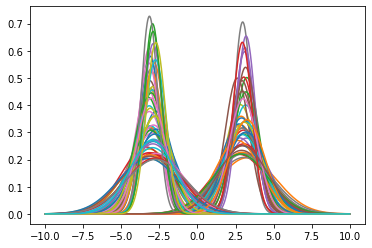

In [8]:
data = simulate_data(100)
xgrid = data[0].pdf_grid
sbasis = SplineBasis(deg=3, xgrid=xgrid, nbasis=nbasis)

for d in data:
    plt.plot(d.pdf_grid, d.pdf_eval)
#     d.compute_inv_cdf(wbasis)


# plt.savefig("scenario1_data.pdf")

In [9]:
spca = SimplicialPCA(nbasis)
spca.fit(data, 5)

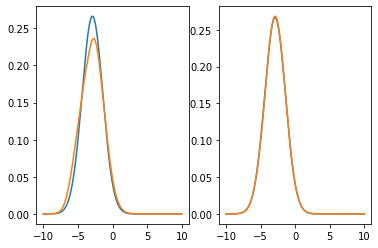

In [10]:
f = data[0]
spca.k = 3

fig, axes = plt.subplots(nrows=1, ncols=2)

reduced = spca.transform([f])
rec = spca.pt_from_proj(reduced) + spca.bary
rec_pdf = spca.get_pdf(rec)

axes[0].plot(f.pdf_grid, f.pdf_eval)
axes[0].plot(f.pdf_grid, rec_pdf[0, :])


spca.k = 10
reduced = spca.transform([f])
rec = spca.pt_from_proj(reduced) + spca.bary
rec_pdf = spca.get_pdf(rec)

axes[1].plot(spca.pdf_grid, f.pdf_eval)
axes[1].plot(spca.pdf_grid, rec_pdf[0, :])

In [15]:
from scipy.interpolate import UnivariateSpline
from pwass.utils import pushforward_density


def invcdf_to_pdf(zero_one_grid, invcdf_eval, s=0.1):
    kept = np.unique(invcdf_eval, return_index=True)[1]
    new_grid = np.linspace(np.min(invcdf_eval), np.max(invcdf_eval), 100)
    cdf = UnivariateSpline(x=invcdf_eval[kept], y=zero_one_grid[kept], s=s)
    der = cdf.derivative()(new_grid)
    return new_grid, der

def plot_wpc(pca, ind, pos_lambdas, neg_lambdas, pos_palette, neg_palette, ax, smooth_val):
    for j, lam in enumerate(pos_lambdas):
        proj = pca.bary + pca.project(lam * pca.eig_vecs[:, ind])
        grid, pdf = invcdf_to_pdf(
            zero_one_grid,
            wbasis.eval_spline(proj), smooth_val)
        # pdf, grid = pushforward_density(wbasis.eval_spline(proj), wbasis.xgrid)
        ax.plot(grid, pdf, color=pos_palette[j])
        
        
    for j, lam in enumerate(neg_lambdas):
        proj = pca.bary + pca.project(lam * pca.eig_vecs[:, ind])
        grid, pdf = invcdf_to_pdf(
            zero_one_grid,
            wbasis.eval_spline(proj), smooth_val)
        ax.plot(grid, pdf, color=neg_palette[j])


def plot_spc(pca, ind, pos_lambdas, neg_lambdas, pos_palette, neg_palette, ax):
    for j, lam in enumerate(pos_lambdas):
        proj = pca.bary + lam * pca.eig_vecs[:, ind]
        ax.plot(pca.spline_basis.xgrid, pca.get_pdf(proj), color=pos_palette[j])
        
        
    for j, lam in enumerate(neg_lambdas):
        proj = pca.bary + lam * pca.eig_vecs[:, ind]
        ax.plot(pca.spline_basis.xgrid, pca.get_pdf(proj), color=neg_palette[j])

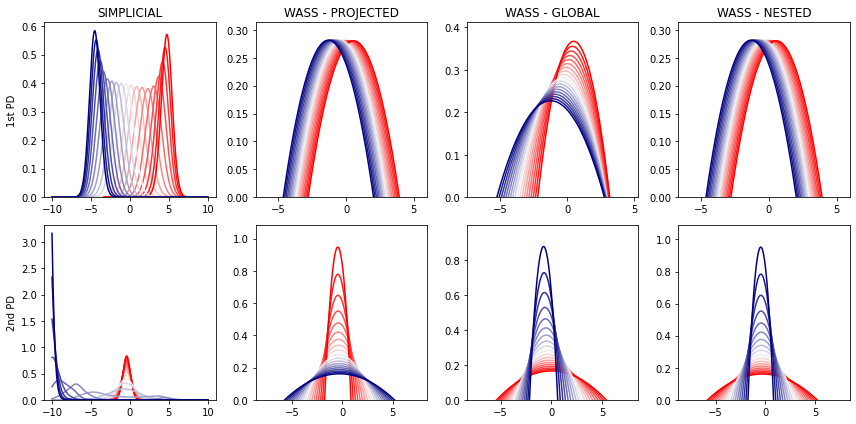

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

pos_lambdas = np.linspace(0.01, 100, 10)
neg_lambdas = np.linspace(-0.01, -100, 10)
pos_palette = sns.light_palette("red", n_colors=len(pos_lambdas))
neg_palette = sns.light_palette("navy", n_colors=len(neg_lambdas))

plot_spc(spca, 0, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[0][0])

pos_lambdas = np.linspace(0.01, 100, 10)
neg_lambdas = np.linspace(-0.01, -100, 10)
plot_spc(spca, 1, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[1][0])
# for i in range(2):
#     axes[0][i].set_xlim(-5, 5)

wpca = ProjectedPCA(20)
wpca.fit(data, 2)
pos_lambdas = np.linspace(0.01, 1, 10)
neg_lambdas = np.linspace(-0.01, -1, 10)
plot_wpc(wpca, 0, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[0][1], 1.0)
plot_wpc(wpca, 1, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[1][1], 10.0)

gpca = GeodesicPCA(20)
gpca.fit(data, 2)
plot_wpc(gpca, 0, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[0][2], 3.5)
plot_wpc(gpca, 1, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[1][2], 10.0)

npca = NestedPCA(20)
npca.fit(data, 2)
plot_wpc(npca, 0, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[0][3], 1.0)
plot_wpc(npca, 1, pos_lambdas, neg_lambdas, pos_palette, neg_palette, axes[1][3], 10.0)


axes[0][0].set_ylabel("1st PD")
axes[1][0].set_ylabel("2nd PD")

axes[0][0].set_title("SIMPLICIAL")
axes[0][1].set_title("WASS - PROJECTED")
axes[0][2].set_title("WASS - GLOBAL")
axes[0][3].set_title("WASS - NESTED")



for i in range(2):
    for j in range(4):
        axes[i][j].set_ylim(ymin=0.0)


plt.tight_layout()
# plt.savefig("scenario1_pca_comparison.pdf")

# comparison of geodesics

In [ ]:
xgrid = np.linspace(-10, 10, 200)
p1un = norm.pdf(xgrid, -4, 0.8)
p2un = norm.pdf(xgrid, 2, 3)

plt.plot(xgrid, p1un)
plt.plot(xgrid, p2un)

In [ ]:
from scipy.integrate import simps
from scipy.interpolate import UnivariateSpline, PchipInterpolator

def inv_clr(f_eval, grid):
    out = np.exp(f_eval)
    den = simps(out, grid)
    return out / den


def clr(f_eval, grid):
        log_f = np.log(f_eval)
        out = log_f - simps(log_f / (grid[-1] - grid[0]), grid)
        return out
    
    
def w_dist(f1, f2):
    qgrid1 = np.cumsum(f1.f_eval) * (f1.grid[1] - f1.grid[0])
    qeval1 = f1.grid
    keep = np.where(np.diff(qgrid1) > 1e-5)
    quant1 = PchipInterpolator(qgrid1[keep], qeval1[keep])
    
    
    qgrid2 = np.cumsum(f2.f_eval) * (f2.grid[1] - f2.grid[0])
    qeval2 = f2.grid
    keep = np.where(np.diff(qgrid2) > 1e-5)
    quant2 = PchipInterpolator(qgrid2[keep], qeval2[keep])
    
    er = np.sqrt(simps( (quant1(zero_one_grid) - quant2(zero_one_grid))**2, zero_one_grid ))
    return er

In [ ]:
import ot
from sklearn.metrics import pairwise_distances

p1 /= np.sum(p1un)
p2 /= np.sum(p2un)

A = np.vstack((p1, p2)).T
n_distributions = A.shape[1]

# loss matrix + normalization
M = pairwise_distances(xgrid.reshape(-1, 1))
M /= M.max()


wgrid = np.concatenate(
    [np.linspace(0, 0.45, 5), np.linspace(0.45, 0.55, 90), np.linspace(0.55, 1.0, 5)])
wass_geod = np.empty((len(wgrid), len(xgrid)))
simp_geod = np.empty((len(wgrid), len(xgrid)))
wass_dists = np.zeros_like(wgrid)
simp_dists = np.zeros_like(wgrid)

p1clr = clr(p1un, xgrid)
p2clr = clr(p2un, xgrid)

dwass = ot.emd2(p1, p2, M)
dsimp = simps( (p2clr - p1clr)**2, xgrid)

for i, w in enumerate(wgrid):
    print("\r{0} / {1}".format(i + 1, len(wgrid)), end=" ", flush=True)
    reg = 1e-3
    wass_geod[i, :] = ot.bregman.barycenter(A, M, reg, np.array([w, 1-w]))
    wass_dists[i] = ot.sinkhorn2(p1, wass_geod[i, :], M, reg)
    
    curr_simp = w * p1clr + (1-w) * p2clr
    simp_geod[i, :] = inv_clr(curr_simp, xgrid)
    simp_dists[i] = simps( (curr_simp - p1clr)**2, xgrid)

In [ ]:
plt.plot(wgrid, wass_dists)
# plt.plot(wgrid, simp_dists)

In [ ]:
dwass = ot.sinkhorn2(p1, p2, M, reg)

In [ ]:
plt.plot(xgrid, p1)
plt.plot(xgrid, p2)
idx = np.where(wass_dists > dwass * 0.25)[0][-1]
print(idx)
plt.plot(xgrid, wass_geod[idx, :])
idx = np.where(wass_dists > dwass * 0.5)[0][-1]
print(idx)
plt.plot(xgrid, wass_geod[idx, :])
idx = np.where(wass_dists > dwass * 0.75)[0][-1]
print(idx)
plt.plot(xgrid, wass_geod[idx, :])

In [ ]:
plt.plot(xgrid, p1un)
plt.plot(xgrid, p2un)
idx = np.where(simp_dists > dsimp * 0.25)[0][-1]
print(idx)
plt.plot(xgrid, simp_geod[idx, :])
idx = np.where(simp_dists > dsimp * 0.5)[0][-1]
print(idx)
plt.plot(xgrid, simp_geod[idx, :])
idx = np.where(simp_dists > dsimp * 0.75)[0][-1]
print(idx)
plt.plot(xgrid, simp_geod[idx, :])

In [ ]:
plt.plot(xgrid, p1)
plt.plot(xgrid, wass_geod[55, :])

# Analysis of simulations

In [ ]:
import pickle

with open("bernstein_sim_res.pickle", "rb") as fp:
    res = pickle.load(fp)

In [ ]:
basis_range = [5, 10, 15, 25, 50]
ncomp_range = [2, 5, 10]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
sim_idx = 0

res["w_errors"][res["w_errors"] > 1] = np.nan
res["w_errors"] = np.ma.array(res["w_errors"], mask=np.isnan(res["w_errors"])) 
res["s_errors"][res["s_errors"] > 1] = np.nan 


for i in range(3):
    mean = np.mean(res["w_errors"][:, i, :], axis=0)
    std = np.std(res["w_errors"][:, i, :], axis=0)
    axes[i].plot(basis_range, mean, label="projected")
    axes[i].fill_between(basis_range, mean + std, mean - std, alpha=0.3)
    
    
    mean = np.mean(res["s_errors"][:, i, :], axis=0)
    std = np.std(res["s_errors"][:, i, :], axis=0)
    axes[i].plot(basis_range, mean, label="simplicial")
    axes[i].fill_between(basis_range, mean + std, mean - std, alpha=0.3)


for i in range(3):
#     axes[i].set_title("# Components: {0}".format(ncomp_range[i]))
    axes[i].set_ylim(0.001, 0.1)  
    axes[i].set_xlim(0, 55)  
    axes[i].set_xticks(np.arange(5, 51, 5))  

axes[2].legend()

plt.tight_layout()
# plt.savefig("bernstein_simulation.pdf")

In [ ]:
res["w_errors"][:, :, -1]

In [ ]:
np.std(res["w_errors"][:, 1, :], axis=0)

In [ ]:
xgrid = np.linspace(0, 1, 1000)
from scipy.stats import norm, gamma, beta, dirichlet


def simulate_data(ndata):
    L = 500
    beta_dens = np.zeros((L, len(xgrid)))
    for j in range(L):
        beta_dens[j, :] = beta.pdf(xgrid, j + 1, L - j)

    out = []
    for i in range(ndata):
        ws = dirichlet.rvs(np.ones(L) * 0.01)[0]
        curr = np.sum(beta_dens * ws[:, np.newaxis], axis=0)
        out.append(GlobalTfunction(xgrid, curr))
    return out

data = simulate_data(100)
for d in data:
    plt.plot(d.grid, d.f_eval)
    
plt.savefig("bernstein_data.pdf")

In [ ]:
import pickle

with open("dpm_sim_res.pickle", "rb") as fp:
    res = pickle.load(fp)

In [ ]:
dim_range = np.arange(2, 10 + 1, 2)

mean = np.mean(res["p_errors"], axis=0)
std = np.std(res["p_errors"], axis=0)
plt.plot(dim_range, mean, label="projected")
plt.fill_between(dim_range, mean + std, mean - std, alpha=0.3)

mean = np.mean(res["s_errors"], axis=0)
std = np.std(res["s_errors"], axis=0)
plt.plot(dim_range, mean, label="simplicial")
plt.fill_between(dim_range, mean + std, mean - std, alpha=0.3)


mean = np.mean(res["n_errors"], axis=0)
std = np.std(res["n_errors"], axis=0)
plt.plot(dim_range, mean, label="nested")
plt.fill_between(dim_range, mean + std, mean - std, alpha=0.3)

mean = np.mean(res["g_errors"], axis=0)
std = np.std(res["g_errors"], axis=0)
plt.plot(dim_range, mean, label="global")
plt.fill_between(dim_range, mean + std, mean - std, alpha=0.3)

plt.yscale("log")
plt.legend()

plt.savefig("dpm_simulation.pdf")
plt.show()

In [ ]:
xgrid = np.linspace(-10, 10, 1000)
from scipy.integrate import simps


def simulate_data(ndata):
    # approximate a DP by truncation
    gamma = 50
    L = 500

    out = []
    for i in range(ndata):
        weights = np.random.dirichlet(np.ones(L) / L, 1)
        atoms = np.empty((L, 2))
        atoms[:, 0] = np.random.normal(loc=0.0, scale=2.0, size=L)
        atoms[:, 1] = np.random.uniform(0.5, 2.0, size=L)
        dens_ = norm.pdf(xgrid.reshape(-1, 1), atoms[:, 0], atoms[:, 1])
        dens = np.sum(dens_ * weights, axis=1)
        dens += 1e-5
        totmass = simps(dens, xgrid)
        dens /= totmass
        out.append(GlobalTfunction(xgrid, dens))
    return out


data = simulate_data(100)
for d in data:
    plt.plot(d.grid, d.f_eval)
    
plt.savefig("dpm_data.pdf")